<a href="https://colab.research.google.com/github/shahabday/NLP_learning/blob/main/DSR_41_HuggingFace_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation with Hugging Face.

# Part 1: Dealing with the dataset.

---

## Check if a GPU is available.

If not, activate it in Runtime -> Change Runtime Type.

In [1]:
!pip install -U transformers[torch] datasets accelerate

In [2]:
import tensorflow as tf
import glob
import os
import shutil
import tqdm
import random
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the dataset. First from the internet. Then from the hard drive.


In [5]:
dataset_file = "dataset.txt"

# How many files to load.
file_number = 100

# Clone the repo.
!git clone https://github.com/vilmibm/lovecraftcorpus

# Find all the files.
paths = glob.glob("lovecraftcorpus/*.txt")

# Do not use all.
paths = paths[:file_number]
print(sorted(paths))

# Merge.
with open(dataset_file, "w") as output_file:
    for path in paths:
        for line in open(path, "r"):
            for split in line.split("\n"):
                split = split.strip()
                if split != "":
                    print(split, file=output_file)

# Delete repo.
!rm -rf lovecraftcorpus

# Done.
print("Corpus downloaded.")

Cloning into 'lovecraftcorpus'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 74 (delta 0), reused 3 (delta 0), pack-reused 70 (from 1)
Receiving objects: 100% (74/74), 1.12 MiB | 2.74 MiB/s, done.
['lovecraftcorpus/alchemist.txt', 'lovecraftcorpus/arthur_jermyn.txt', 'lovecraftcorpus/azathoth.txt', 'lovecraftcorpus/beast.txt', 'lovecraftcorpus/beyond_wall_of_sleep.txt', 'lovecraftcorpus/book.txt', 'lovecraftcorpus/celephais.txt', 'lovecraftcorpus/charles_dexter_ward.txt', 'lovecraftcorpus/clergyman.txt', 'lovecraftcorpus/colour_out_of_space.txt', 'lovecraftcorpus/cool_air.txt', 'lovecraftcorpus/crawling_chaos.txt', 'lovecraftcorpus/cthulhu.txt', 'lovecraftcorpus/dagon.txt', 'lovecraftcorpus/descendent.txt', 'lovecraftcorpus/doorstep.txt', 'lovecraftcorpus/dreams_in_the_witch.txt', 'lovecraftcorpus/dunwich.txt', 'lovecraftcorpus/erich_zann.txt', 'lovecraftcorpus/ex_oblivione.txt', 'lovec

In [3]:
import os
import kagglehub
import shutil

# Define the folder where the dataset will be stored
output_folder = "/content/scripts"

# Ensure the directory exists
os.makedirs(output_folder, exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("divyansh22/friends-tv-show-script")

print("✅ Dataset downloaded and saved in:", path)

# Copy all files from the source path to the destination
shutil.copytree(path, output_folder, dirs_exist_ok=True)



100%|██████████| 1.67M/1.67M [00:00<00:00, 126MB/s]

Extracting files...
✅ Dataset downloaded and saved in: /root/.cache/kagglehub/datasets/divyansh22/friends-tv-show-script/versions/1


'/content/scripts'

In [4]:
dataset_file = '/content/scripts/Friends_Transcript.txt'
raw_datasets = load_dataset("text", data_files=[dataset_file])
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 66540
    })
})

Let us look at an example.

In [5]:
for index in range(10):
    token_sequence = raw_datasets["train"][index]["text"]
    print(token_sequence)

THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)
Written by: Marta Kauffman & David Crane
[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]
Monica: There's nothing to tell! He's just some guy I work with!
Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!
Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
Phoebe: Wait, does he eat chalk?
(They all stare, bemused.)
Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!
Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.


# Part 2: Training GPT-2.

---

## Train the tokenizer.

In [6]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=5000, special_tokens=["[UNK]", "[PAD]"])
tokenizer.pre_tokenizer = Whitespace()

def batch_iterator(batch_size=1000):
    for i in range(0, len(raw_datasets["train"]), batch_size):
        yield raw_datasets["train"][i : i + batch_size]["text"]

tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(raw_datasets["train"]))
tokenizer.save("tokenizer.json")

tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [9]:
tokenizer.vocab_size

5000

In [7]:
tokenizer.vocab

{'display': 4733,
 'inet': 3755,
 'my': 183,
 'oney': 722,
 'pact': 4971,
 'Day': 1793,
 'li': 162,
 'Hold': 1557,
 'father': 1296,
 'dancing': 2115,
 'power': 3747,
 'ouder': 4978,
 'unfair': 4995,
 'Episode': 4131,
 'Ye': 3962,
 'fr': 900,
 'instead': 2737,
 'tech': 3519,
 'youve': 1774,
 'isnt': 1541,
 'ount': 3162,
 'read': 427,
 'sister': 1199,
 'Both': 2499,
 'Five': 3862,
 'annoy': 2532,
 'clock': 2252,
 'Susan': 1207,
 'ium': 4330,
 'alone': 1407,
 'marry': 1779,
 'may': 1299,
 'rab': 4833,
 'Itll': 4712,
 'explain': 2431,
 'Cha': 3103,
 'Wait': 697,
 'cate': 3308,
 'involved': 4127,
 '...?': 2428,
 'Val': 3261,
 'pregn': 1515,
 'ITS': 3193,
 'Or': 1225,
 'ellent': 2759,
 '::': 2420,
 'meant': 1812,
 'Mee': 4617,
 'OR': 2779,
 'categor': 4642,
 'lap': 1398,
 'dia': 2947,
 'wouldn': 1674,
 'Lea': 3349,
 'S': 52,
 'closet': 2946,
 'exits': 1911,
 'hundred': 2097,
 'Parker': 2918,
 'wasnt': 1635,
 'ges': 3124,
 '20': 2326,
 'Con': 2993,
 'date': 841,
 'ness': 2039,
 'll': 108,
 'S

In [8]:
from transformers import GPT2Tokenizer

#tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#tokenizer.save("tokenizer.json")
#tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
#tokenizer.add_special_tokens({'pad_token': '[PAD]'})

## Tokenize some samples.

Inspect the vocabulary.

In [9]:
token_sequence = raw_datasets["train"][3]["text"]
print(token_sequence)

indices = tokenizer(token_sequence)["input_ids"]
print(indices)

tokens = [tokenizer.decode([index]) for index in indices]
print(tokens)
print(len(tokens))

Monica: There's nothing to tell! He's just some guy I work with!
[139, 27, 599, 8, 83, 916, 107, 363, 2, 170, 8, 83, 185, 242, 263, 42, 572, 193, 2]
['Monica', ':', 'There', "'", 's', 'nothing', 'to', 'tell', '!', 'He', "'", 's', 'just', 'some', 'guy', 'I', 'work', 'with', '!']
19


100%|██████████| 66540/66540 [00:07<00:00, 8991.15it/s]


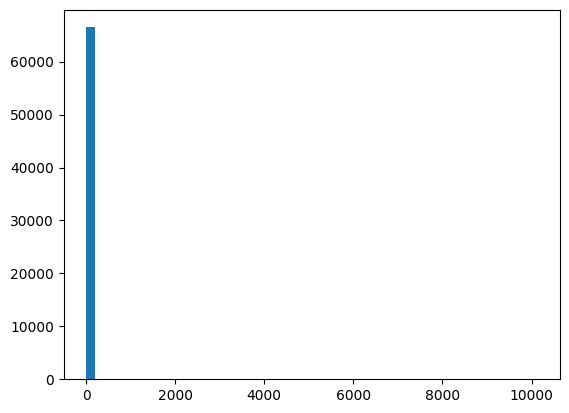

In [10]:
lengths = []
for token_sequence in tqdm.tqdm(raw_datasets["train"]):
    token_sequence = token_sequence["text"]
    indices = tokenizer(token_sequence)["input_ids"]
    lengths += [len(indices)]

plt.hist(lengths, bins=50)
plt.show()

## Train the model.

Prepare the tokenization function.

In [11]:
sequence_length = 256

def tokenize_function(example):
    tokenized_example = tokenizer(
        example["text"],
        truncation=True,
        padding=True,
        max_length=sequence_length,
    )
    return {
        "input_ids": tokenized_example["input_ids"]
    }

# Check a sample.
token_sequence = raw_datasets["train"][0]
print(token_sequence)
tokenized = tokenize_function(token_sequence)
assert list(tokenized.keys()) == ["input_ids"], list(tokenized.keys())
print(tokenized)

{'text': 'THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)'}
{'input_ids': [851, 1147, 2682, 577, 4316, 53, 52, 34, 4952, 56, 459, 48, 46, 2193, 38, 9, 851, 49, 42, 3864, 53, 14, 851, 2886, 36, 54, 53, 4326, 52, 42, 455, 10]}


Create the tokenized dataset.

In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=raw_datasets["train"].column_names)

# Check a sample.
tokenized = tokenized_datasets["train"][0]
assert list(tokenized.keys()) == ["input_ids"], list(tokenized.keys())
print(tokenized)

Map:   0%|          | 0/66540 [00:00<?, ? examples/s]

{'input_ids': [851, 1147, 2682, 577, 4316, 53, 52, 34, 4952, 56, 459, 48, 46, 2193, 38, 9, 851, 49, 42, 3864, 53, 14, 851, 2886, 36, 54, 53, 4326, 52, 42, 455, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Instantiate a data collator.

In [13]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Create the model.

In [14]:
model_config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    n_ctx=sequence_length,
    n_embd=512,
    n_head=8,
    n_layer=6,
    n_positions=sequence_length,
)
model = GPT2LMHeadModel(model_config)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(5000, 512)
    (wpe): Embedding(256, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=1536, nx=512)
          (c_proj): Conv1D(nf=512, nx=512)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=2048, nx=512)
          (c_proj): Conv1D(nf=512, nx=2048)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=512, out_features=5000, bias=False)
)

## Test the data collator and the model.

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


input_ids: tensor([[ 60, 249,  27, 634, 646,  13, 138,  13, 136,  13, 148,  13, 104, 139,
         178, 252, 230,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   

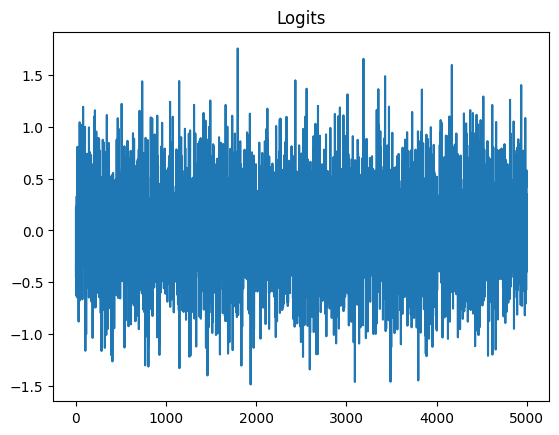

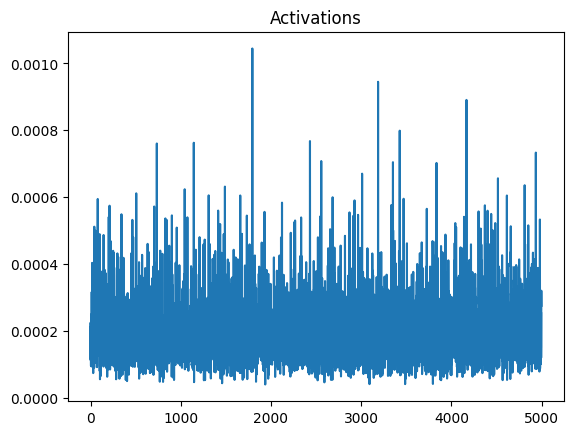

In [15]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs)
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

---

## Run the training.


In [16]:
# Get the output directory with timestamp.
output_path = "output"

# Create the trainer.
print("Creating trainer...")
training_args = TrainingArguments(
    output_dir=output_path,
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=128,
    prediction_loss_only=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
)

# Train the model.
trainer.train()

# Save the tokenizer.
tokenizer.save_pretrained(output_path)

# Save the model.
model.save_pretrained(output_path)

Creating trainer...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: shahabdaiani (shahabdaiani-dsr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
500,4.891000
1000,4.182600
1500,3.985900
2000,3.853600
2500,3.768400
3000,3.697500
3500,3.633000
4000,3.593000
4500,3.556500
5000,3.528300


input_ids: tensor([[ 60, 249,  27, 634, 646,  13, 138,  13, 136,  13, 148,  13, 104, 139,
         178, 252, 230,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   

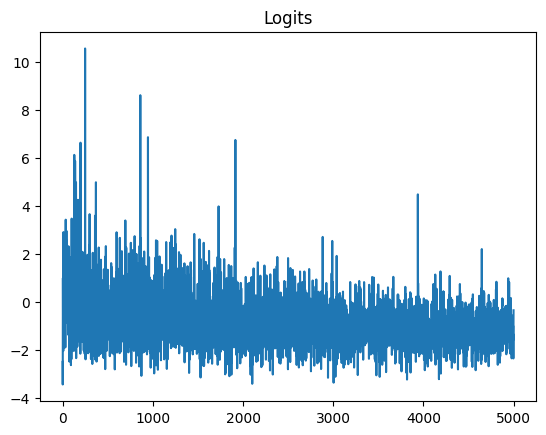

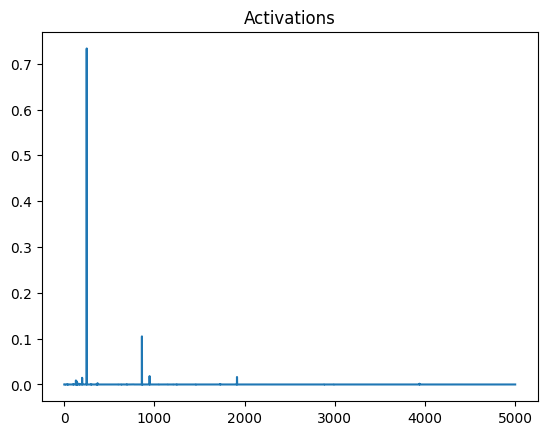

In [17]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs.to("cuda:0"))
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].cpu().detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.cpu().detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

## How to generate.

In [19]:
# Encode the conditioning tokens.
input_ids = tokenizer.encode("Episod 5 . Ross is sitting on the couch", return_tensors="pt").cuda()
print(input_ids)

# Generate more tokens.
generated_ids = model.generate(
    input_ids,
    max_length=100,
    do_sample=True,
    temperature=0.5
)
generated_sequence = tokenizer.decode(generated_ids[0], clean_up_tokenization_spaces=True)
print(generated_sequence)

tensor([[3731, 2310,   68,   22,   15,  129,  109,  754,   98,  100,  784]],
       device='cuda:0')
Ep iso d 5. Ross is sitting on the couch. ( He walks in to the bathroom.) Hey, you know, there's no one to your wife. ( He sits down.) Okay, you're really good, you're gonna be fine. ( To Chandler ) You're not having to take them. You're not the woman who're going to do you're gonna be in the morning. You're thinking, you're a lot of my


#Thank you!